<a href="https://colab.research.google.com/github/ayakandil1/Data-Engineering/blob/main/De_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""DE_GIU.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1RYAihLnV2Y-T-s2xO6sWwAGxapZXFO2v
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




In [2]:
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

print("Libraries loaded successfully.")

"""### Load the Crashes"""

crashes_url = "https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD"

print("Loading crashes dataset")

df_crashes = pd.read_csv(crashes_url, low_memory=False)

print("Crashes dataset shape:", df_crashes.shape)
df_crashes.head()




Libraries loaded successfully.
Loading crashes dataset
Crashes dataset shape: (2222046, 29)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,2.0,0.0,0,0,0,0,2,0,Aggressive Driving/Road Rage,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,1.0,0.0,0,0,0,0,1,0,Pavement Slippery,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,1.0,0.0,0,0,0,0,1,0,Unspecified,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [3]:
# Only columns needed for integration
persons_url = "https://data.cityofnewyork.us/api/views/f55k-p6yu/rows.csv?accessType=DOWNLOAD"
useful_cols = [
    "COLLISION_ID",
    "PERSON_TYPE",
    "PERSON_INJURY",
    "PERSON_AGE",
    "PERSON_SEX"
]

chunk_size = 200_000  # safe for free Colab
persons_chunks = []

print("Loading PERSONS dataset in chunks...")

for chunk in pd.read_csv(persons_url, usecols=useful_cols, chunksize=chunk_size, low_memory=False):
    persons_chunks.append(chunk)

Loading PERSONS dataset in chunks...


In [4]:
# Concatenate all chunks into one DataFrame
df_persons = pd.concat(persons_chunks, ignore_index=True)

print("Persons dataset loaded successfully.")
print("Persons dataset shape:", df_persons.shape)
df_persons.head()

"""### Clean Column Names"""

df_crashes.columns = df_crashes.columns.str.upper().str.replace(" ", "_")
df_persons.columns = df_persons.columns.str.upper().str.replace(" ", "_")

df_crashes.head()

"""### Convert Date & Time Columns"""

df_crashes["CRASH_DATE"] = pd.to_datetime(df_crashes["CRASH_DATE"], errors="coerce")
df_crashes["CRASH_TIME"] = pd.to_datetime(df_crashes["CRASH_TIME"], format="%H:%M", errors="coerce").dt.time

df_crashes["YEAR"] = df_crashes["CRASH_DATE"].dt.year
# Fill missing years with a value (e.g., -1) or drop them

df_crashes['YEAR'] = df_crashes['YEAR'].fillna(-1).astype('int16')

df_crashes["MONTH"] = df_crashes["CRASH_DATE"].dt.month

Persons dataset loaded successfully.
Persons dataset shape: (5825115, 5)


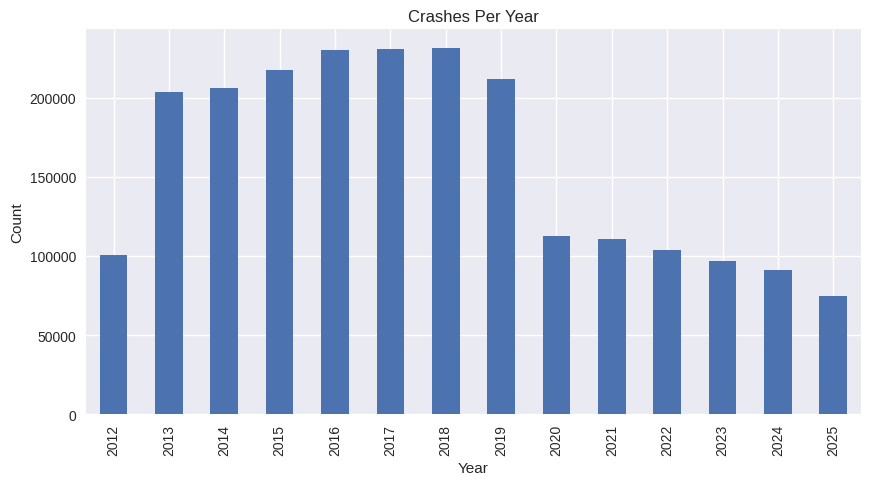

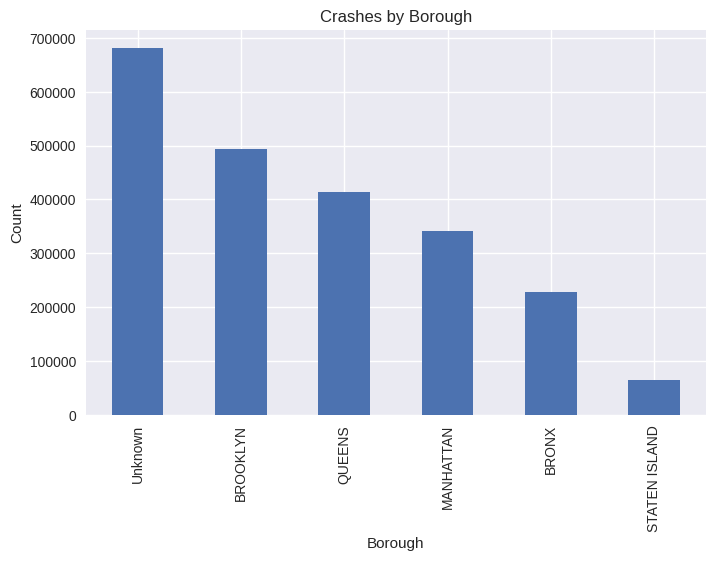

In [5]:
"""### **EDA**"""

plt.figure(figsize=(10,5))
df_crashes['YEAR'].value_counts().sort_index().plot(kind='bar')
plt.title("Crashes Per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,5))
df_crashes['BOROUGH'].fillna('Unknown').value_counts().plot(kind='bar')
plt.title("Crashes by Borough")
plt.xlabel("Borough")
plt.ylabel("Count")
plt.show()


In [6]:
# =========================
# Pre-Integration Cleaning
# =========================
# Drop crashes with no location
df_crashes = df_crashes[~(df_crashes["LATITUDE"].isna() & df_crashes["LONGITUDE"].isna())].copy()

# Fill missing boroughs
df_crashes["BOROUGH"] = df_crashes["BOROUGH"].fillna("Unknown")

# Convert injury/killed columns
injury_cols = [c for c in df_crashes.columns if "INJURED" in c or "KILLED" in c]
for col in injury_cols:
    df_crashes[col] = pd.to_numeric(df_crashes[col], errors="coerce").fillna(0).astype("int16")

# Remove duplicates
before = df_crashes.shape[0]
df_crashes = df_crashes.drop_duplicates(subset=["COLLISION_ID"])
after = df_crashes.shape[0]
print(f"Removed {before - after} duplicate rows.")

# =========================
# Merge Crashes with Persons
# =========================
df_merged = df_crashes.merge(df_persons, on="COLLISION_ID", how="left")
print("Merged dataset shape:", df_merged.shape)

# =========================
# Post-Integration Cleaning
# =========================
df_merged["PERSON_TYPE"] = df_merged["PERSON_TYPE"].fillna("Unknown").str.title()
df_merged["PERSON_INJURY"] = df_merged["PERSON_INJURY"].fillna("Unknown")
df_merged["PERSON_SEX"] = df_merged["PERSON_SEX"].fillna("Unknown")
df_merged["PERSON_AGE"] = df_merged["PERSON_AGE"].fillna(-1).astype("int16")  # -1 = missing age

# =========================
# Additional Feature Engineering
# =========================
# Time features
df_merged["CRASH_HOUR"] = df_merged["CRASH_TIME"].apply(lambda x: x.hour if pd.notnull(x) else -1).astype('int8')
df_merged["DAY_OF_WEEK"] = df_merged["CRASH_DATE"].dt.day_name().astype('category')
df_merged["IS_WEEKEND"] = df_merged["CRASH_DATE"].dt.weekday >= 5

# Crash severity
df_merged["TOTAL_PERSON_INJURED"] = df_merged[injury_cols].sum(axis=1)
if "NUMBER_OF_PERSONS_KILLED" in df_merged.columns:
    df_merged["FATAL"] = df_merged["NUMBER_OF_PERSONS_KILLED"] > 0

# Sanity check for age
df_merged.loc[(df_merged["PERSON_AGE"] < 0) | (df_merged["PERSON_AGE"] > 120), "PERSON_AGE"] = -1

# Optional: fill missing ages by PERSON_TYPE median
median_age = df_merged.groupby("PERSON_TYPE")["PERSON_AGE"].median()
df_merged["PERSON_AGE"] = df_merged.apply(
    lambda row: median_age[row["PERSON_TYPE"]] if row["PERSON_AGE"] == -1 else row["PERSON_AGE"],
    axis=1
).astype('int16')

# =========================
# Convert object columns to categorical
# =========================
for col in df_merged.select_dtypes(include='object').columns:
    if df_merged[col].nunique() / len(df_merged) < 0.5:
        df_merged[col] = df_merged[col].astype('category')

# =========================
# Downcast numeric columns to save memory
# =========================
for col in df_merged.select_dtypes(include='int64').columns:
    df_merged[col] = pd.to_numeric(df_merged[col], downcast='integer')
for col in df_merged.select_dtypes(include='float64').columns:
    df_merged[col] = pd.to_numeric(df_merged[col], downcast='float')

print("Final preprocessing complete.")
print("Final dataset shape:", df_merged.shape)
df_merged.head()

Removed 0 duplicate rows.
Merged dataset shape: (5817912, 35)
Final preprocessing complete.
Final dataset shape: (5817912, 40)


,CRASH_DATE,CRASH_TIME,BOROUGH,ZIP_CODE,LATITUDE,LONGITUDE,LOCATION,ON_STREET_NAME,CROSS_STREET_NAME,OFF_STREET_NAME,NUMBER_OF_PERSONS_INJURED,NUMBER_OF_PERSONS_KILLED,NUMBER_OF_PEDESTRIANS_INJURED,NUMBER_OF_PEDESTRIANS_KILLED,NUMBER_OF_CYCLIST_INJURED,NUMBER_OF_CYCLIST_KILLED,NUMBER_OF_MOTORIST_INJURED,NUMBER_OF_MOTORIST_KILLED,CONTRIBUTING_FACTOR_VEHICLE_1,CONTRIBUTING_FACTOR_VEHICLE_2,CONTRIBUTING_FACTOR_VEHICLE_3,CONTRIBUTING_FACTOR_VEHICLE_4,CONTRIBUTING_FACTOR_VEHICLE_5,COLLISION_ID,VEHICLE_TYPE_CODE_1,VEHICLE_TYPE_CODE_2,VEHICLE_TYPE_CODE_3,VEHICLE_TYPE_CODE_4,VEHICLE_TYPE_CODE_5,YEAR,MONTH,PERSON_TYPE,PERSON_INJURY,PERSON_AGE,PERSON_SEX,CRASH_HOUR,DAY_OF_WEEK,IS_WEEKEND,TOTAL_PERSON_INJURED,FATAL
0,2023-11-01,01:29:00,BROOKLYN,11230,40.621792,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,1,0,0,0,0,0,1,0,Unspecified,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN,2023,11,Occupant,Unspecified,63,F,1,Wednesday,False,2,False
1,2023-11-01,01:29:00,BROOKLYN,11230,40.621792,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,1,0,0,0,0,0,1,0,Unspecified,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN,2023,11,Occupant,Injured,26,M,1,Wednesday,False,2,False
2,2021-09-11,09:35:00,BROOKLYN,11208,40.667202,-73.866501,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,0,0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN,2021,9,Occupant,Unspecified,28,F,9,Saturday,True,0,False
3,2021-09-11,09:35:00,BROOKLYN,11208,40.667202,-73.866501,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,0,0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN,2021,9,Occupant,Unspecified,28,F,9,Saturday,True,0,False
4,2021-12-14,08:13:00,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN,2021,12,Pedestrian,Unspecified,46,M,8,Tuesday,False,0,False


In [7]:
!pip install Dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 76.7 MB/s eta 0:00:00


In [13]:
!ngrok authtoken 35ngpJUauQWbsWVwBoPxgn96FB9_txzyhh72hctAsXk84W6c


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install pyngrok


In [ ]:
# =========================
# Libraries
# =========================

from pyngrok import ngrok
import dash
from dash import dcc, html, Input, Output, State
import plotly.express as px
import pandas as pd

# =========================
# Use preprocessed dataset
# =========================
df = df_merged.copy()

# Ensure YEAR is numeric
df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce')

# =========================
# Initialize Dash app
# =========================
app = dash.Dash(__name__)
app.title = "NYC Traffic Crashes Dashboard"

# =========================
# Layout
# =========================
app.layout = html.Div([
    html.H1("NYC Traffic Crashes Dashboard", style={'textAlign': 'center'}),

    html.Div([
        html.Div([
            html.Label("Borough:"),
            dcc.Dropdown(
                id='borough-dropdown',
                options=[{'label': b, 'value': b} for b in sorted(df['BOROUGH'].dropna().unique())],
                multi=True,
                placeholder="Select borough(s)"
            ),
        ], style={'width': '48%', 'display': 'inline-block'}),

        html.Div([
            html.Label("Year:"),
            dcc.Dropdown(
                id='year-dropdown',
                options=[{'label': int(y), 'value': int(y)} for y in sorted(df['YEAR'].dropna().unique())],
                multi=True,
                placeholder="Select year(s)"
            ),
        ], style={'width': '48%', 'display': 'inline-block', 'marginLeft': '4%'}),
    ], style={'marginBottom': '20px'}),

    html.Div([
        html.Label("Injury Type:"),
        dcc.Dropdown(
            id='injury-dropdown',
            options=[{'label': i, 'value': i} for i in sorted(df['PERSON_INJURY'].dropna().unique())],
            multi=True,
            placeholder="Select injury type(s)"
        ),
    ], style={'marginBottom': '20px'}),

    html.Button('Generate Report', id='generate-button', n_clicks=0, style={'marginBottom': '20px'}),

    html.Div([
        dcc.Tabs([
            dcc.Tab(label='Bar Chart', children=[dcc.Graph(id='bar-chart')]),
            dcc.Tab(label='Line Chart', children=[dcc.Graph(id='line-chart')]),
            dcc.Tab(label='Pie Chart', children=[dcc.Graph(id='pie-chart')]),
            dcc.Tab(label='Map', children=[dcc.Graph(id='map-chart')]),
        ])
    ])
])

# =========================
# Callback
# =========================
@app.callback(
    Output('bar-chart', 'figure'),
    Output('line-chart', 'figure'),
    Output('pie-chart', 'figure'),
    Output('map-chart', 'figure'),
    Input('generate-button', 'n_clicks'),
    State('borough-dropdown', 'value'),
    State('year-dropdown', 'value'),
    State('injury-dropdown', 'value')
)
def update_charts(n_clicks, boroughs, years, injuries):
    # Filtered data for map and line chart
    dff_filtered = df.copy()
    if boroughs:
        dff_filtered = dff_filtered[dff_filtered['BOROUGH'].isin(boroughs)]
    if years:
        dff_filtered = dff_filtered[dff_filtered['YEAR'].isin(years)]
    if injuries:
        dff_filtered = dff_filtered[dff_filtered['PERSON_INJURY'].isin(injuries)]

    # ================== BAR CHART ==================
    bar_data = df.groupby('YEAR').size().reset_index(name='Crashes').sort_values('YEAR')
    if years:
        bar_data['Color'] = bar_data['YEAR'].apply(lambda x: 'Selected' if x in years else 'Other')
        bar_fig = px.bar(
            bar_data,
            x='YEAR', y='Crashes', text='Crashes',
            color='Color',
            color_discrete_map={'Selected': 'crimson', 'Other': 'lightgrey'},
            title='Number of Crashes by Year'
        )
    else:
        bar_fig = px.bar(bar_data, x='YEAR', y='Crashes', text='Crashes', title='Number of Crashes by Year')

    # ================== LINE CHART ==================
    line_data = dff_filtered.groupby('YEAR').size().reset_index(name='Crashes').sort_values('YEAR')
    line_fig = px.line(
        line_data,
        x='YEAR', y='Crashes',
        title='Crashes Over Years'
    )

    # ================== PIE CHART ==================
    pie_data = df.groupby('PERSON_INJURY').size().reset_index(name='Count')
    if injuries:
        pie_data['Color'] = pie_data['PERSON_INJURY'].apply(lambda x: 'Selected' if x in injuries else 'Other')
        pie_fig = px.pie(
            pie_data,
            names='PERSON_INJURY', values='Count',
            title='Distribution of Injury Types',
            color='Color',
            color_discrete_map={'Selected': 'crimson', 'Other': 'lightgrey'}
        )
    else:
        pie_fig = px.pie(pie_data, names='PERSON_INJURY', values='Count', title='Distribution of Injury Types')

    # ================== MAP ==================
    map_fig = None
    if 'LATITUDE' in dff_filtered.columns and 'LONGITUDE' in dff_filtered.columns:
        valid_map_data = dff_filtered.dropna(subset=['LATITUDE', 'LONGITUDE'])
        if not valid_map_data.empty:
            map_fig = px.scatter_mapbox(
                valid_map_data,
                lat='LATITUDE',
                lon='LONGITUDE',
                color='BOROUGH',
                hover_data=['CRASH_DATE', 'PERSON_INJURY', 'PERSON_TYPE'],
                zoom=9,
                height=600
            )
            map_fig.update_layout(mapbox_style="open-street-map")
        else:
            map_fig = px.scatter(title="No geolocation data available")
    else:
        map_fig = px.scatter(title="No geolocation data available")

    return bar_fig, line_fig, pie_fig, map_fig

# =========================
# Open ngrok tunnel and run Dash
# =========================
public_url = ngrok.connect(8050)
print("Your Dash app is live at:", public_url)

app.run(port=8050)


Your Dash app is live at: NgrokTunnel: "https://picky-jeneva-sacrilegiously.ngrok-free.dev" -> "http://localhost:8050"
Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8050
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [22/Nov/2025 09:03:48] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Nov/2025 09:03:49] "GET /_dash-component-suites/dash/deps/polyfill@7.v3_3_0m1763802056.12.1.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Nov/2025 09:03:49] "GET /_dash-component-suites/dash/deps/react@18.v3_3_0m1763802056.3.1.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Nov/2025 09:03:49] "GET /_dash-component-suites/dash/deps/react-dom@18.v3_3_0m1763802056.3.1.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Nov/2025 09:03:49] "GET /_dash-component-suites/dash/deps/prop-types@15.v3_3_0m1763802056.8.1.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Nov/2025 09:03:49] "GET /_dash-component-suites/dash/dash-renderer/build/dash_renderer.v3_3_0m17638020